In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [10]:
# Load dataset
base_dir = '../Datasets/UTKFace'
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(base_dir):
    image_path = os.path.join(base_dir, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [11]:
df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset

# Gender dictionary
gender_dic = {0: 'Male', 1: 'Female'}

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


In [12]:
# Data Generator to load images efficiently with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [13]:
train_generator = datagen.flow_from_dataframe(
    train_df, x_col='image', y_col=['gender', 'age'], target_size=(224, 224), batch_size=32, class_mode='multi_output')

val_generator = datagen.flow_from_dataframe(
    val_df, x_col='image', y_col=['gender', 'age'], target_size=(224, 224), batch_size=32, class_mode='multi_output')


Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [14]:
# Define custom CNN model
input_shape = (224, 224, 3)
inputs = Input(input_shape)

# Convolutional layers with increasing filter sizes
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

# Flatten the output for dense layers
flatten = Flatten()(maxp_4)

# Fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dropout_1 = Dropout(0.5)(dense_1)

# Output layers
out_gender = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
out_age = Dense(1, activation='linear', name='age_out')(dropout_1)

# Model compilation
model = Model(inputs=[inputs], outputs=[out_gender, out_age])
model.compile(loss=['binary_crossentropy', 'mean_squared_error'], optimizer='adam', metrics=['accuracy', 'mae'])

# Model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [15]:
# Implement a learning rate scheduler to adjust learning rate if validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=30, 
    callbacks=[lr_scheduler]
)

Epoch 1/30
593/593 [==============================] - 400s 664ms/step - loss: 417.0453 - gender_out_loss: 1.0973 - age_out_loss: 415.9479 - gender_out_accuracy: 0.5004 - gender_out_mae: 0.5009 - age_out_accuracy: 0.0470 - age_out_mae: 15.6272 - val_loss: 389.1531 - val_gender_out_loss: 0.7241 - val_age_out_loss: 388.4292 - val_gender_out_accuracy: 0.5312 - val_gender_out_mae: 0.4821 - val_age_out_accuracy: 0.0485 - val_age_out_mae: 14.7383 - lr: 0.0010
Epoch 2/30
593/593 [==============================] - 218s 367ms/step - loss: 357.0198 - gender_out_loss: 0.7027 - age_out_loss: 356.3172 - gender_out_accuracy: 0.5383 - gender_out_mae: 0.4884 - age_out_accuracy: 0.0471 - age_out_mae: 14.5227 - val_loss: 315.5750 - val_gender_out_loss: 0.6717 - val_age_out_loss: 314.9034 - val_gender_out_accuracy: 0.5624 - val_gender_out_mae: 0.4666 - val_age_out_accuracy: 0.0485 - val_age_out_mae: 13.7067 - lr: 0.0010
Epoch 3/30
593/593 [==============================] - 220s 371ms/step - loss: 297.2044

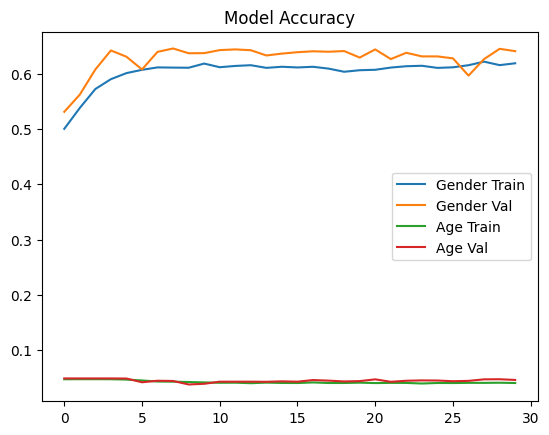

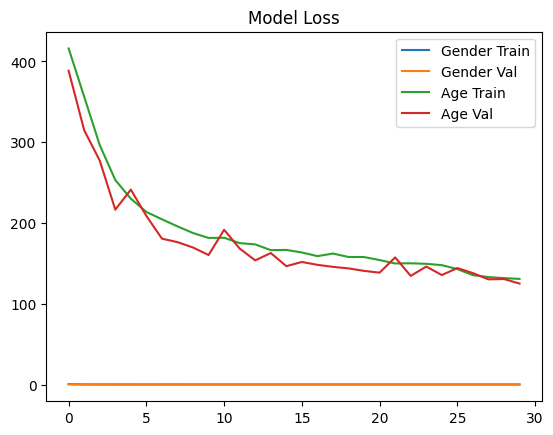

In [16]:
# Plot accuracy and loss
def plot_history(history, metric, title):
    plt.plot(history.history[f'gender_out_{metric}'], label='Gender Train')
    plt.plot(history.history[f'val_gender_out_{metric}'], label='Gender Val')
    plt.plot(history.history[f'age_out_{metric}'], label='Age Train')
    plt.plot(history.history[f'val_age_out_{metric}'], label='Age Val')
    plt.title(title)
    plt.legend()
    plt.show()

# Plot model performance
plot_history(history, 'accuracy', 'Model Accuracy')
plot_history(history, 'loss', 'Model Loss')

In [18]:
def print_predicted_vs_actual_ages(model, val_generator, num_images=10):
    # Get a batch of validation images and their labels
    val_images, val_labels = next(val_generator)

    # Get predicted ages from the model
    predicted_gender, predicted_age = model.predict(val_images)

    # Get the actual ages from the validation labels
    actual_age = val_labels[1]  # The second column of val_labels corresponds to age

    # Print predicted vs actual ages for the specified number of validation images
    for i in range(num_images):
        print(f"Image {i+1} - Actual Age: {actual_age[i]}, Predicted Age: {int(predicted_age[i][0])}")

# Call the function to print predicted vs actual ages for the first 10 validation images
print_predicted_vs_actual_ages(model, val_generator, num_images=10)

1/1 [==============================] - 0s 40ms/step
Image 1 - Actual Age: 39, Predicted Age: 33
Image 2 - Actual Age: 40, Predicted Age: 44
Image 3 - Actual Age: 56, Predicted Age: 45
Image 4 - Actual Age: 30, Predicted Age: 28
Image 5 - Actual Age: 53, Predicted Age: 64
Image 6 - Actual Age: 36, Predicted Age: 39
Image 7 - Actual Age: 3, Predicted Age: 1
Image 8 - Actual Age: 34, Predicted Age: 33
Image 9 - Actual Age: 31, Predicted Age: 30
Image 10 - Actual Age: 28, Predicted Age: 29


In [19]:
model.save("../Models/ageModel2.h5")